In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
from collections import defaultdict
from Solver import solver
import Solver_V2
import utilities as util

# Lectura de Datos

In [2]:
df = pd.read_csv("datos_arreglados.csv", encoding="latin1")
df = df[df["ID"] > 60]

In [3]:
#df.rename(columns={'Ethical technology assessment?':'Ethical technology assessment'}, inplace=True)

bach = df[df['program'] == 'bachelor'] #selecciona las tuplas de bachelor en un df
mast = df[df['program'] == 'master'] #selecciona las tuplas master en un df

b_aal = bach[bach['campus'] == 'AAL'] #selecciona las tuplas bachelor aal en df
m_aal = mast[mast['campus'] == 'AAL'] #selecciona las tuplas master aal en df

b_cph = bach[bach['campus'] == 'CPH'] #selecciona las tuplas bachelor cph en df
m_cph = mast[mast['campus'] == 'CPH'] #selecciona las tuplas master cph en df

esb = df[df['campus'] == 'ESB'] #selecciona las tuplas esb en df

In [4]:
col1 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most4' 
col2 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most5'
col3 = 'Select 3 workshops in a prioritised order, where 1 is the workshop you want to attend the most6'

cursos_b_aal = sorted(set(b_aal[col1]) | set(b_aal[col2]) | set(b_aal[col3])) #talleres disponibles para bachelor aal, en base a los seleccionados en top 3
cursos_m_aal = sorted(set(m_aal[col1]) | set(m_aal[col2]) | set(m_aal[col3])) #talleres disponibles para master aal,  en base a los seleccionados en top 3

cursos_b_cph = sorted(set(b_cph[col1]) | set(b_cph[col2]) | set(b_cph[col3])) #talleres disponibles para bachelor cph, en base a los seleccionados en top 3
cursos_m_cph = sorted(set(m_cph[col1]) | set(m_cph[col2]) | set(m_cph[col3])) #talleres disponibles para master cph,  en base a los seleccionados en top 3

cursos_esb = sorted(set(esb[col1]) | set(esb[col2]) | set(esb[col3])) #talleres disponibles para esb, en base a los seleccionados en top 3


#selecciona columnas de los nombres de curso, donde cada columna posee NaN, 1, 2, 3 indicando preferencia top 3 o no
pref_b_aal = b_aal[cursos_b_aal] 
pref_m_aal = m_aal[cursos_m_aal] 

pref_b_cph = b_cph[cursos_b_cph]
pref_m_cph = m_cph[cursos_m_cph]

pref_esb = esb[cursos_esb]

In [5]:
pref_esb.head()

,Clarification of individual professional competences,Collaboration across discplines,Creativity and entrepeneurship,Digital and hybrid practices in collaborative work,Digital practices in project work,Ethical technology assessment,Facilitation of productive meeting,Generative AI in study practices?,Interdisciplinary problem design,Leadership and project management,"Motivation, well-being and work-life balance?",Professional communication with external partners,Professional identity development,Psychological safety in team work,Psychological safety in teamwork,SCRUM-techniques in project work?,Systems thinking in engineering
11,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN
16,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0


Establecer preferencias de estudiantes

In [6]:
#ejemplo:
util.get_dict(pref_m_aal, 1)                     # Para saber preferencia de estudiante 
                                            # s en opcion i. se aplica t_pref[s][i]
                                            # OJO: Las columnas se aleatorizan en cada kernel

{1: 1, 2: 5, 3: 2}

# Implementación

In [7]:
# Elegir Programa y campus
pref = pref_m_aal

# Setear Parámetros
(S, T, H, C, U, t_pref, D, p) = util.get_par(pref)

D[1] = 1                                # el taller 1 es de día completo
C = [4, 4]                              # capacidad de talleres por horario (AM, PM)
U = [100 for _ in range(pref.shape[1])] # capacidad de cada taller (todos con 150 cupos)

pref.head()


,Clarification of individual professional competences,Creative and systems thinking for complex problem-solving (whole day workshop - you are then attending 1 workshop the whole day),Digital and hybrid practices in collaborative work,Ethical technology assessment,Leadership and project management,Professional communication with external partners,Professional identity development,Psychological safety in team work
13,1.0,3.0,NaN,NaN,NaN,NaN,2.0,NaN
15,NaN,1.0,3.0,NaN,NaN,2.0,NaN,NaN
20,1.0,NaN,NaN,3.0,NaN,NaN,2.0,NaN
21,1.0,NaN,NaN,3.0,NaN,NaN,2.0,NaN
24,3.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN


In [13]:
# 0 al final para que no hable tanto, 1 si quiero más infor
modelo, y, z, w = solver(S, T, H, C, U, t_pref, D, p, 0)
#modelo, y, z, w = Solver_V2.solver(S, T, H, C, U, t_pref, D, p, 0)

Set parameter TimeLimit to value 1800


In [26]:
#si falla ver la razón
"""
if model.status == GRB.INFEASIBLE:
    print("Modelo es infeasible. Buscando IIS...")
    
    # Computar IIS
    model.computeIIS()
    
    # Mostrar restricciones y variables en conflicto
    print("\nRestricciones en conflicto:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(c.ConstrName)
    
    print("\nVariables involucradas en conflicto:")
    for v in model.getVars():
        if v.IISLB or v.IISUB:
            print(v.VarName)
"""

'\nif model.status == GRB.INFEASIBLE:\n    print("Modelo es infeasible. Buscando IIS...")\n\n    # Computar IIS\n    model.computeIIS()\n\n    # Mostrar restricciones y variables en conflicto\n    print("\nRestricciones en conflicto:")\n    for c in model.getConstrs():\n        if c.IISConstr:\n            print(c.ConstrName)\n\n    print("\nVariables involucradas en conflicto:")\n    for v in model.getVars():\n        if v.IISLB or v.IISUB:\n            print(v.VarName)\n'

# Resultados

In [14]:
# En promedio, puntaje por alumno
modelo.ObjVal / (len(S) - 1)

11.78061224489796

In [15]:
util.ver_talleres(z)

El taller 0 fue elegido para realizarse
El taller 1 fue elegido para realizarse
El taller 2 no se realizará
El taller 3 fue elegido para realizarse
El taller 4 fue elegido para realizarse
El taller 5 fue elegido para realizarse
El taller 6 fue elegido para realizarse
El taller 7 fue elegido para realizarse


In [16]:
talleres_AM, talleres_PM = util.talleres_horarios(y)

El taller 0 se da en el horario AM
El taller 1 se da en el horario AM
El taller 1 se da en el horario PM
El taller 3 se da en el horario AM
El taller 4 se da en el horario AM
El taller 5 se da en el horario PM
El taller 6 se da en el horario PM
El taller 7 se da en el horario PM


In [17]:
print("Talleres AM")
for i in talleres_AM:
    print("- Taller " + str(i))

print("Talleres PM")
for i in talleres_PM:
    print("- Taller " + str(i))

Talleres AM
- Taller 0
- Taller 1
- Taller 3
- Taller 4
Talleres PM
- Taller 1
- Taller 5
- Taller 6
- Taller 7


In [47]:
dic_asignaciones_realizadas = util.ver_asignaciones(w)

El estudiante 0 fue asignado al taller 0
El estudiante 0 fue asignado al taller 6
El estudiante 1 fue asignado al taller 1
El estudiante 2 fue asignado al taller 0
El estudiante 2 fue asignado al taller 6
El estudiante 3 fue asignado al taller 0
El estudiante 3 fue asignado al taller 6
El estudiante 4 fue asignado al taller 4
El estudiante 4 fue asignado al taller 7
El estudiante 5 fue asignado al taller 3
El estudiante 5 fue asignado al taller 5
El estudiante 6 fue asignado al taller 1
El estudiante 7 fue asignado al taller 1
El estudiante 8 fue asignado al taller 0
El estudiante 8 fue asignado al taller 5
El estudiante 9 fue asignado al taller 3
El estudiante 9 fue asignado al taller 7
El estudiante 10 fue asignado al taller 3
El estudiante 10 fue asignado al taller 7
El estudiante 11 fue asignado al taller 1
El estudiante 12 fue asignado al taller 3
El estudiante 12 fue asignado al taller 7
El estudiante 13 fue asignado al taller 1
El estudiante 14 fue asignado al taller 3
El estudi

In [48]:
print(dic_asignaciones_realizadas) #key: estudiante, value:[talleres asignados]

{0: [0, 6], 1: [1], 2: [0, 6], 3: [0, 6], 4: [4, 7], 5: [3, 5], 6: [1], 7: [1], 8: [0, 5], 9: [3, 7], 10: [3, 7], 11: [1], 12: [3, 7], 13: [1], 14: [3, 7], 15: [4, 7], 16: [0, 5], 17: [4, 7], 18: [0, 7], 19: [3, 7], 20: [4, 7], 21: [4, 7], 22: [3, 6], 23: [4, 6], 24: [3, 7], 25: [1], 26: [3, 5], 27: [1], 28: [0, 5], 29: [0, 5], 30: [0, 5], 31: [0, 5], 32: [3, 7], 33: [0, 7], 34: [4, 7], 35: [4, 7], 36: [0, 5], 37: [0, 6], 38: [0, 5], 39: [0, 5], 40: [4, 5], 41: [1], 42: [4, 5], 43: [0, 7], 44: [0, 5], 45: [3, 6], 46: [4, 7], 47: [0, 7], 48: [3, 6], 49: [3, 6], 50: [3, 6], 51: [0, 6], 52: [3, 5], 53: [3, 6], 54: [3, 7], 55: [3, 5], 56: [0, 7], 57: [4, 7], 58: [1], 59: [0, 7], 60: [1], 61: [3, 6], 62: [1], 63: [3, 6], 64: [4, 5], 65: [0, 5], 66: [4, 6], 67: [0, 5], 68: [0, 5], 69: [1], 70: [4, 6], 71: [0, 5], 72: [4, 6], 73: [1], 74: [1], 75: [3, 6], 76: [4, 7], 77: [1], 78: [1], 79: [4, 5], 80: [4, 7], 81: [3, 6], 82: [4, 6], 83: [1], 84: [3, 5], 85: [3, 6], 86: [4, 6], 87: [3, 6], 88: 

# Estadísticas

In [49]:
contador_primera_opt = 0
contador_segunda_opt = 0
contador_tercera_opt = 0

for s in range(len(S) - 1):
    if t_pref[s][1] in dic_asignaciones_realizadas[s]:
        contador_primera_opt += 1
    if t_pref[s][2] in dic_asignaciones_realizadas[s]:
        contador_segunda_opt += 1
    if t_pref[s][3] in dic_asignaciones_realizadas[s]:
        contador_tercera_opt += 1

print(contador_primera_opt)
print(contador_segunda_opt)
print(contador_tercera_opt)

370
153
46


In [51]:
for key, value in dic_asignaciones_realizadas.items():
    if len(value) != 2:
        print(f"Al estudiante {key} se le asignó taller(es) {value}, verificar si es taller de 1 día completo o fallo")

Al estudiante 1 se le asignó taller(es) [1], verificar si es taller de 1 día completo o fallo
Al estudiante 6 se le asignó taller(es) [1], verificar si es taller de 1 día completo o fallo
Al estudiante 7 se le asignó taller(es) [1], verificar si es taller de 1 día completo o fallo
Al estudiante 11 se le asignó taller(es) [1], verificar si es taller de 1 día completo o fallo
Al estudiante 13 se le asignó taller(es) [1], verificar si es taller de 1 día completo o fallo
Al estudiante 25 se le asignó taller(es) [1], verificar si es taller de 1 día completo o fallo
Al estudiante 27 se le asignó taller(es) [1], verificar si es taller de 1 día completo o fallo
Al estudiante 41 se le asignó taller(es) [1], verificar si es taller de 1 día completo o fallo
Al estudiante 58 se le asignó taller(es) [1], verificar si es taller de 1 día completo o fallo
Al estudiante 60 se le asignó taller(es) [1], verificar si es taller de 1 día completo o fallo
Al estudiante 62 se le asignó taller(es) [1], verific

In [52]:
#contar cuanto se llenó cada taller
capacidad_real_taller = defaultdict(int) #la key es el id del taller 0, 1,... y el value es la cantidad de alumnos asignados a este taller en la solución
for key, value in dic_asignaciones_realizadas.items():
    for taller in value:
       capacidad_real_taller[taller] += 1 

for taller, cantidad in capacidad_real_taller.items():
    print(f"El taller {taller} tiene {cantidad} alumnos, está un {100*(cantidad/U[taller])}% lleno")

El taller 0 tiene 99 alumnos, está un 99.0% lleno
El taller 6 tiene 99 alumnos, está un 99.0% lleno
El taller 1 tiene 98 alumnos, está un 98.0% lleno
El taller 4 tiene 100 alumnos, está un 100.0% lleno
El taller 7 tiene 95 alumnos, está un 95.0% lleno
El taller 3 tiene 95 alumnos, está un 95.0% lleno
El taller 5 tiene 100 alumnos, está un 100.0% lleno


In [53]:
suma_AM = 0
suma_PM = 0
for taller in talleres_AM:
    suma_AM += capacidad_real_taller[taller]
for taller in talleres_PM:
    suma_PM += capacidad_real_taller[taller]
print(suma_AM)
print(suma_PM)

392
392


### Visualizar algunas asignaciones de talleres vs lo que eligió

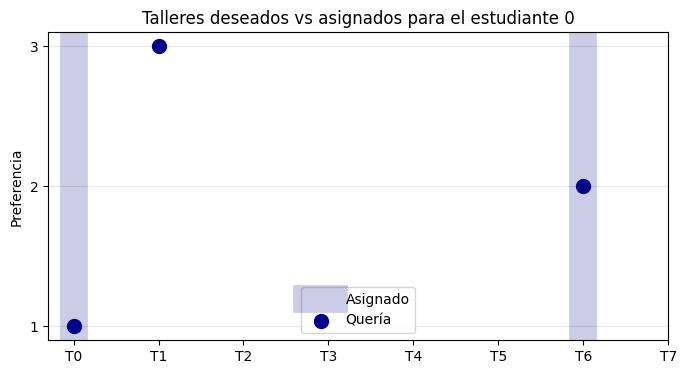

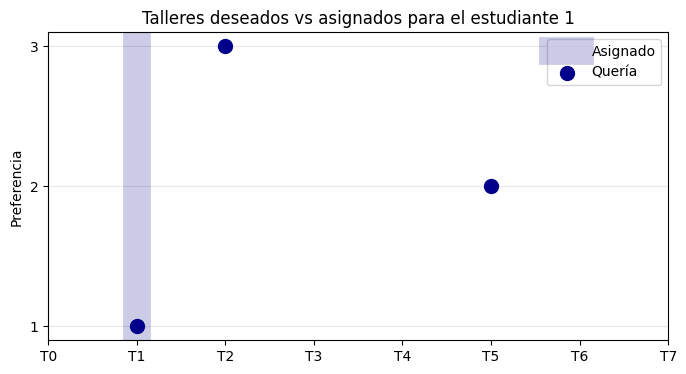

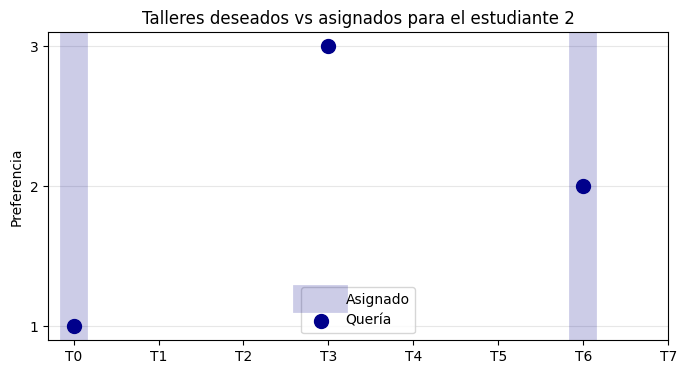

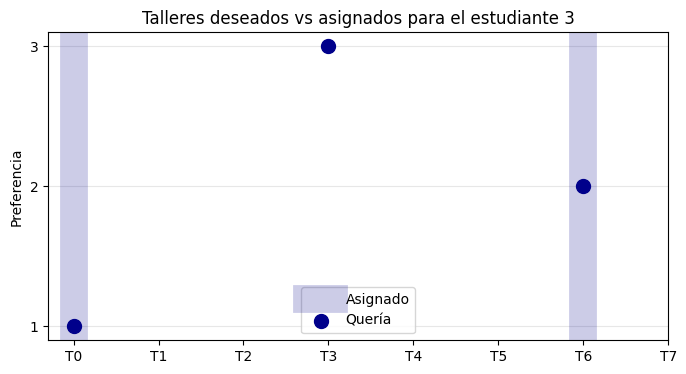

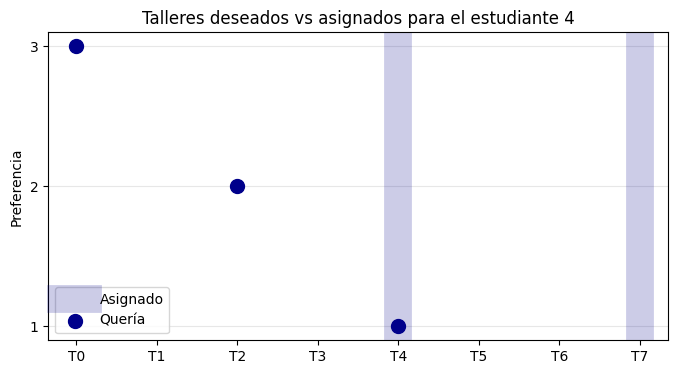

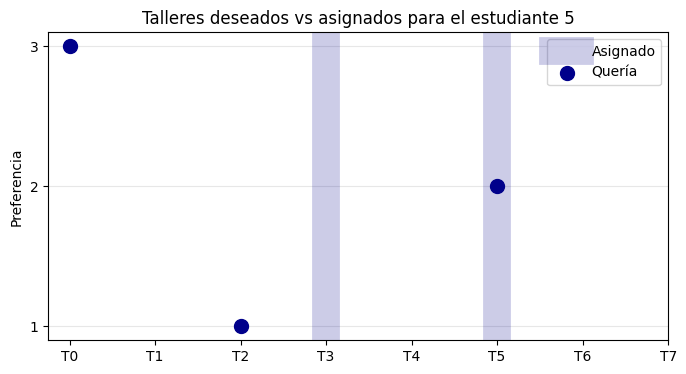

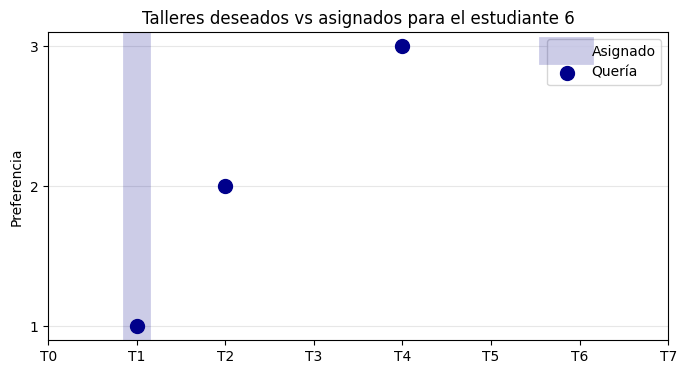

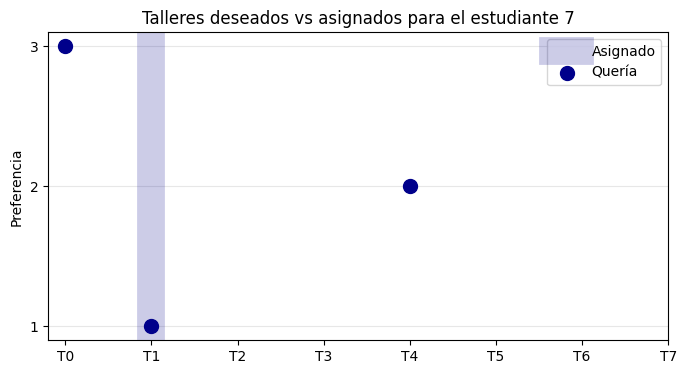

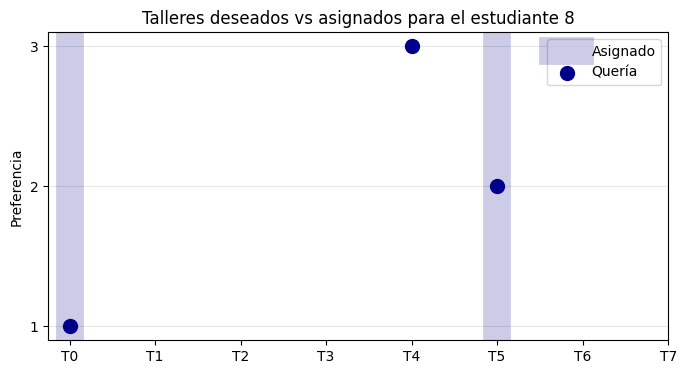

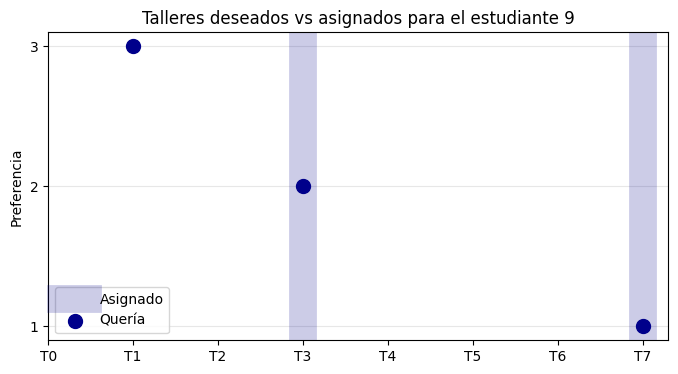

In [55]:
#visualizar la asignación de talleres
talleres = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
#para los estudiantes 0 al 9 muestra los talleres que quería y a los que fue asignado
for i in range(10):
    n_estudiante = i
    preferencias = util.get_dict(pref_m_aal, n_estudiante) #preferencia, taller
    asignados = dic_asignaciones_realizadas[i] #asignaciones que se les dio
    
    plt.figure(figsize=(8, 4))
    #sombrear las columnas de los talleres asignados
    for t in asignados:
        plt.axvline(x=t, color='darkblue', alpha=0.2, linewidth=20, label='Asignado' if t == asignados[0] else "")
    
    #marcar los puntos de las preferencias
    for pref, t in preferencias.items():
        plt.scatter(t, pref, color='darkblue', s=100, zorder=3, label='Quería' if pref == 1 else "")
    
    plt.xticks(range(len(talleres)), talleres)
    plt.yticks(range(1, 4))
    plt.ylabel('Preferencia')
    plt.title(f'Talleres deseados vs asignados para el estudiante {i}')
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

# Estudiar por orden de llegada

Aca primero necesitaríamos alguna forma de seleccionar los talleres que se harían:

1. Hacer talleres con mayoría.
2. Probar combinaciones y elegir mejor: Hay 1575 formas de asignar

In [12]:
talleres_AM_realizar = [0, 1, 2, 3] 
talleres_PM_realizar = [4, 5, 6, 7] 

In [14]:
asignaciones = [[] for i in range(10)]

In [ ]:
def asignar(estudiante, asign, t_AM, t_PM):
    pref_1 = t_pref[estudiante][1]
    pref_1 = t_pref[estudiante][2]
    pref_1 = t_pref[estudiante][3]

In [ ]:
for j in S:
    

In [15]:
t_pref[0][1]

2